# 1. PubMed

Search PubMed for papers

https://www.ncbi.nlm.nih.gov/pubmed/

https://www.ncbi.nlm.nih.gov/books/NBK25499/

In [80]:
from collections import Counter
import datetime
import os

import lcp.reuse as reuse
from Bio import Entrez
from IPython.display import display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Define folders

In [1]:
SEARCH_RESULT_FOLDER = 'search_results'
MIMIC_PUBMED_CITATION_FOLDER = 'MIMIC_Pubmed_Citations'

# Define search queries

In [2]:
MIMIC_QUERY = '(mimic-ii OR mimic-iii OR mimic-iv OR mimicii OR mimiciii OR mimiciv OR mimic-2 OR mimic-3 OR mimic-4 OR mimic2 OR mimic3 OR mimic4)'

In [4]:
PROJECT = 'MIMIC' #'eICU'

def full_query(base_query, restriction_query):
    return ' AND '.join([base_query, restriction_query])

entrez_email = 'mimic-support@physionet.org'
if PROJECT == 'MIMIC':
    PMID = None
elif PROJECT == 'eICU':
    # Retrieves publications which cite this reference
    PMID = '30204154'

if PROJECT == 'MIMIC':
    base_query = MIMIC_QUERY
elif PROJECT == 'eICU':
    base_query = f'(eicu-crd OR "eICU Collaborative Research Database" OR (eicu AND ({MIMIC_QUERY} OR database OR MIT OR Phillips)))'
# Other terms added to remove false positives. The more terms added without increasing FPs, the better.
if PROJECT == 'MIMIC':
    restriction_query = '(physionet OR icu OR "intensive care" OR "critical care")'
elif PROJECT == 'eICU':
    restriction_query = '("intensive care" OR "critical care")'
# more restriction keyword ideas: clinical, database, waveform (not suitable on their own due to general mimic term)
full_query = full_query(base_query, restriction_query)

if PMID:
    search_strings = [
        'PMID'
    ]
else:
    search_strings = [
        #base_query#,
        full_query
    ]

In [ ]:
# search_results = reuse.search_list(search_strings, entrez_email)
if PMID:
    citations = []
    pmc_ids = Entrez.read(Entrez.elink(dbfrom='pubmed', db='pmc', LinkName='pubmed_pmc_refs', from_uid=PMID))
    pmc_ids = [list(i.values())[0] for i in pmc_ids[0]['LinkSetDb'][0]['Link']]
    pm_ids = Entrez.read(Entrez.elink(dbfrom='pmc', db='pubmed', LinkName='pmc_pubmed', from_uid=','.join(pmc_ids)))
    for pm_id in [list(i.values())[0] for i in pm_ids[0]['LinkSetDb'][0]['Link']]:
        citations.append(pm_id)
    search_results_all = reuse.search_list(entrez_email, ids=citations, all=True)
else:
    search_results_all = reuse.search_list(entrez_email, search_strings=search_strings, all=True)

In [ ]:
# Display number of results
if PMID:
    result = search_results_all['PMID']
    print(f'PMID:\n - Count: {len(result.index)}')
else:
    for ss in search_strings:
        result = search_results_all[ss]
        print(f'{ss}:\n - Count: {len(result.index)}')

In [ ]:
# Write the titles to files
write_dir = os.path.join(SEARCH_RESULT_FOLDER, PROJECT, 'pubmed')
os.makedirs(write_dir, exist_ok=True)

if PMID:
    search_results_all['PMID'].to_csv(os.path.join(write_dir, 'PMID-citations-all.csv'), index=False)
else:
    search_results_all[base_query].to_csv(os.path.join(write_dir, 'without-constraints-all.csv'), index=False)
    search_results_all[full_query].to_csv(os.path.join(write_dir, 'with-constraints-all.csv'), index=False)

# base_query_file = os.path.join(write_dir, 'without-constraints.txt')
# with open(base_query_file, 'w') as f:
#     for line in search_results[base_query].paper_titles:
#         f.write(line+'\n')

# full_query_file = os.path.join(write_dir, 'with-constraints.txt')
# with open(full_query_file, 'w') as f:
#     for line in search_results[full_query].paper_titles:
#         f.write(line+'\n')

In [ ]:
# Create a new one for each year
if PMID:
    all_years = sorted(set(list(search_results_all['PMID']['Publication Year'])))
    for year in all_years:
        year_df = search_results_all['PMID'][search_results_all['PMID']['Publication Year'] == year]
        year_df.to_csv(os.path.join(write_dir, f'PMID-citations-all_{year}.csv'), index=False)
else:
    all_years = sorted(set(list(search_results_all[full_query]['Publication Year'])))
    for year in all_years:
        year_df_without = search_results_all[base_query][search_results_all[base_query]['Publication Year'] == year]
        year_df_with = search_results_all[full_query][search_results_all[full_query]['Publication Year'] == year]
        year_df_without.to_csv(os.path.join(write_dir, f'without-constraints-all_{year}.csv'), index=False)
        year_df_with.to_csv(os.path.join(write_dir, f'with-constraints-all_{year}.csv'), index=False)

In [ ]:
# Create a histogram of number of publications each year
if PMID:
    all_years = sorted(set(list(search_results_all['PMID']['Publication Year'])))

    years = []
    for year in all_years:
        year_df = search_results_all['PMID'][search_results_all['PMID']['Publication Year'] == year]

        for _ in range(len(year_df.index)):
            years.append(year)

    plt.figure(figsize=(10,6))
    plt.hist(years, facecolor='k', edgecolor='w', bins=np.arange(len(all_years)+1)-0.5)
    plt.savefig(os.path.join(write_dir, 'PMID-citations_histogram.jpg'))
    plt.xlabel('Year', fontsize=12)
    plt.ylabel('Number of Publications', fontsize=12)
    plt.show()
else:
    all_years = sorted(set(list(search_results_all[full_query]['Publication Year'])))

    year_without = []
    year_with = []
    for year in all_years:
        year_df_without = search_results_all[base_query][search_results_all[base_query]['Publication Year'] == year]
        year_df_with = search_results_all[full_query][search_results_all[full_query]['Publication Year'] == year]

        for _ in range(len(year_df_without.index)):
            year_without.append(year)
        for _ in range(len(year_df_with.index)):
            year_with.append(year)

    plt.figure(figsize=(10,6))
    plt.hist(year_without, facecolor='k', edgecolor='w', bins=np.arange(len(all_years)+1)-0.5)
    plt.savefig(os.path.join(write_dir, 'without-constraints_histogram.jpg'))
    plt.xlabel('Year', fontsize=12)
    plt.ylabel('Number of Publications', fontsize=12)
    plt.show()

    plt.figure(figsize=(10,6))
    plt.hist(year_with, facecolor='k', edgecolor='w', bins=np.arange(len(all_years)+1)-0.5)
    plt.savefig(os.path.join(write_dir, 'with-constraints_histogram.jpg'))
    plt.xlabel('Year', fontsize=12)
    plt.ylabel('Number of Publications', fontsize=12)
    plt.show()

In [ ]:
# DO: Create a file called without-constraints-inspected.tsv and mark the second column with T/F for true/false positives.


In [ ]:
# Look at the effect of restricting the search by additional criteria.
# The differences show that many false positives, and a few true positives, are removed.
reuse.showdiff(search_results[search_strings[0]],
               search_results[search_strings[1]])

In [ ]:
# Read in the labelled results for the general unconstrained search query
labelled_results = pd.read_csv(os.path.join(write_dir, 'without-constraints-inspected.tsv'), delimiter='\t', header=None)
false_positives = labelled_results.loc[labelled_results[1]=='F'][0].values
true_positives = labelled_results.loc[labelled_results[1]=='T'][0].values
print('Number of results found using the unconstrained search term:', len(labelled_results))
print('Number of false positives:',len(false_positives))
print('Number of true positives:',len(true_positives))

constrained_titles = search_results[search_strings[1]].paper_titles
print('\nCompare ^ true positives with:')
print('Number of results from the constrained search term:', len(constrained_titles))

missed_papers = set(true_positives) - set(constrained_titles)
print('Number of missed true positives:', len(missed_papers))

In [ ]:
# Take a look at some True positives missed by the constrained search term to figure out what else you can add.
# Write to a file to label comments.
write_dir = os.path.join(SEARCH_RESULT_FOLDER, 'pubmed')

missed_papers_file = os.path.join(write_dir, 'missed-papers.tsv')

with open(missed_papers_file, 'w') as f:
    for line in missed_papers:
        f.write(line+'\n')

display(missed_papers)

# 2. Web of Science

In [ ]:
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
import re
import time
from IPython.display import display


restriction_query = '(physionet OR icu OR “intensive care” OR “critical care”)'
def full_query(base_query, restriction_query):
    return ' AND '.join([base_query, restriction_query])
full_mimic_query = full_query(MIMIC_QUERY, restriction_query)
#base_search_url = 'https://apps.webofknowledge.com/WOS_GeneralSearch_input.do?product=WOS&search_mode=GeneralSearch&SID=2F46AeWkMQBRAZlzDWm&preferencesSaved='
base_search_url = 'https://apps.webofknowledge.com/WOS_GeneralSearch_input.do?product=WOS&search_mode=GeneralSearch&SID=1AnC2UMojuKrtrl7T5R&preferencesSaved='

all_titles = []

In [ ]:
# Get to the search page
driver = webdriver.Firefox()
driver.get(base_search_url)

# Input the query string
time.sleep(2.5)
searchbox = driver.find_element_by_id('value(input1)')
searchbox.send_keys(full_mimic_query)

# Search
time.sleep(1)
searchbutton = driver.find_element_by_css_selector('.standard-button.primary-button.large-search-button')
searchbutton.click()

# Get the total number of pages
npages = int(driver.find_element_by_id('pageCount.top').text)

In [ ]:
# Get the titles!!!
while True:
    # Get the current page number
    pagenum = int(driver.find_element_by_class_name('goToPageNumber-input').get_property('value'))

    # Get the titles. This also captures the journals. So every second value is not a title.
    elements = driver.find_elements_by_class_name('smallV110')

    for e in elements[::2]:
        all_titles.append(e.find_element_by_tag_name('value').text)
        
    if pagenum < npages:
        nextbutton = driver.find_element_by_class_name('paginationNext')
        nextbutton.click()
    else:
        print('Got all paper titles!')
        driver.close()
        break
        
all_titles = set(all_titles)
#all_titles.remove('')
all_titles = [t.lower() for t in list(all_titles)]

In [ ]:
display(all_titles)

In [ ]:
# Write the titles to files
write_dir = os.path.join('search_results/wos')

full_query_file = os.path.join(write_dir, 'with-constraints.txt')

with open(full_query_file, 'w') as f:
    for line in all_titles:
        f.write(line+'\n')

# 3. SCOPUS

Shit search

# 4. IEEE

In [ ]:
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
import re
import time
from IPython.display import display
import os

restriction_query = '(physionet OR icu OR “intensive care” OR “critical care”)'
def full_query(base_query, restriction_query):
    return ' AND '.join([base_query, restriction_query])
full_mimic_query = full_query(MIMIC_QUERY, restriction_query)
base_search_url = 'http://ieeexplore.ieee.org/search/advsearch.jsp?expression-builder'
all_titles = []

In [ ]:
# Get to the search page
driver = webdriver.Firefox()
driver.get(base_search_url)

# Input the query string
searchbox = driver.find_element_by_id('expression-textarea')
searchbox.send_keys(full_mimic_query)
# Select the 'full text and metadata' box
radiobutton = driver.find_element_by_id('Search_All_Text')
radiobutton.click()

# Search
time.sleep(1)
searchbutton = driver.find_element_by_class_name('stats-Adv_Command_search')
searchbutton.click()

# Get the total number of pages
#npages = int(driver.find_element_by_id('pageCount.top').text)

In [ ]:
# Get the titles!!!
while True:
    # let the page load
    time.sleep(2)
    # Get scroll height
    last_height = driver.execute_script("return document.body.scrollHeight")
    while True:
        driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
        time.sleep(0.5)
        new_height = driver.execute_script("return document.body.scrollHeight")
        if new_height == last_height:
            break
        last_height = new_height
        
    # Get the titles.
    # They are in: <h2 class="result-item-title"><a class="ng-binding ng-scope">title</a></h2>
    elements = driver.find_elements_by_class_name('result-item-title')
    for e in elements:
        # Text may appear with "[::sometext::]"
        all_titles.append(e.find_element_by_tag_name('a').get_attribute('text').replace('[::', '').replace('::]', ''))
        # New line separated journal info and such
        #all_titles.append(e.text.split('\n')[0])
    
    # Click next page if any
    
    e = driver.find_element_by_class_name('next')
    if 'disabled' in e.get_attribute('class'):
        print('Got all paper titles!')
        driver.close()
        break
    else:
        nextbutton = driver.find_element_by_link_text('>')
        nextbutton.click()

all_titles = set(all_titles)
all_titles = [t.lower() for t in list(all_titles)]

In [ ]:
print(len(all_titles))
display(all_titles)

In [ ]:
# Write the titles to files
write_dir = os.path.join('search_results/ieee')

full_query_file = os.path.join(write_dir, 'with-constraints.txt')

with open(full_query_file, 'w') as f:
    for line in all_titles:
        f.write(line+'\n')

# Combining Results - pubmed, wos, ieee

In [ ]:
result_dir = SEARCH_RESULT_FOLDER

combined_results = []
for service in ['pubmed', 'wos', 'ieee']:
    # For pubmed, get the curated true positives from the unconstrained search instead
    if service == 'pubmed':
        df = pd.read_csv(os.path.join(result_dir, service, 'without-constraints-inspected.tsv'), delimiter='\t', header=None)
        service_results = list(df.loc[df[1]=='T'][0].values)
    # For other services, get the constrained search results
    else:
        with open(os.path.join(result_dir, service, 'with-constraints.txt')) as f:
            service_results = f.readlines()
    print('Number of results from service '+service+': '+str(len(service_results)))
    combined_results = combined_results + [r.strip() for r in service_results]

print('\nTotal number of non-unique results: ', len(combined_results))
combined_results = sorted(list(set(combined_results)))
print('Total number of unique results: ', len(combined_results))
with open(os.path.join(result_dir, 'combined', 'with-constraints.txt'), 'w') as f:
    for r in combined_results:
        f.write(r+'\n')

In [ ]:
# may 21 2018
Number of results from service pubmed: 155
Number of results from service wos: 152
Number of results from service ieee: 322

Total number of non-unique results:  629
Total number of unique results:  456


# Attempting to parse GS automatically failed. Below is evidence of failure. Can ignore...

# N. Search Google Scholar

Packages found online:
- https://github.com/ckreibich/scholar.py
- https://github.com/venthur/gscholar
- https://github.com/adeel/google-scholar-scraper
- http://code.activestate.com/recipes/523047-search-google-scholar/
- https://github.com/erdiaker/torrequest
- https://github.com/NikolaiT/GoogleScraper


- https://stackoverflow.com/questions/8049520/web-scraping-javascript-page-with-python


Query: `("mimic ii" OR "mimic iii") AND ("database" OR "clinical" OR "waveform" OR ICU)`

https://scholar.google.com/scholar?q=%28mimic-ii+OR+mimic-iii%29&btnG=&hl=en&as_sdt=1%2C22&as_vis=1

https://scholar.google.com/scholar/help.html


https://superuser.com/questions/565722/how-to-config-tor-to-use-a-http-socks-proxy

## Requirements

1. Browse with JS enabled. requests library uses http. Otherwise google will think (correctly) that you are a robot.
2. Change IP every time, or google will block.

In [ ]:
from scholarly import scholarly

In [ ]:
PROJECT = 'eICU'

# Search by Google Scholar publication ID
search_results = []
if PROJECT == 'eICU':
    try:
        search_results.append(scholarly.search_citedby(11878669525996073977))
    except Exception as e:
        print(e)

total_results = search_results[0].total_results

In [ ]:
# all_pubs = list(search_results)
all_pubs = []
for i in range(total_results):
    print(100*i/total_results)
    try:
        ct = next(search_results)
        all_pubs.append({
            'title': ct['bib']['title'],
            'pub_year': ct['bib']['pub_year']
        })
    except:
        pass
# print(all_pubs)

# Manually get the number of citations from Google Scholar
## Methods:
### 1. Go to: https://scholar.google.com/
### 2. Type a query to get a specific MIMIC DB, i.e., "`mimic-iv`" for MIMIC-IV
### 3. Find the original paper (usually the first result, or top cited one)
### 4. Click on "`Cited by ###`" underneath the brief abstract
### 5. On the left side, click "`Custom range...`"
### 6. In both boxes, type the year you want to query, i.e., "`2023 - 2023`" to return results for only 2023, click "`Search`"
### 7. At the top, under the search bar is the number of citations that year (note, the "`About ### results`" is the exact number of results until around 1000 or so when it rounds to the nearest 20 I think due to the massive pagination request but still close enough at those numbers)

----
### TODO: automate this!!! but I know GS will get mad at me for all those requests ...

In [66]:
google_scholar_mimic_pubs = {
    'mimic-i': {
        '1997' :   2,
        '1998' :   1,
        '1999' :   2,
        '2000' :   4,
        '2001' :   4,
        '2002' :   4,
        '2003' :   3,
        '2004' :   7,
        '2005' :   5,
        '2006' :  10,
        '2007' :  12,
        '2008' :   3,
        '2009' :   9,
        '2010' :  10,
        '2011' :  12,
        '2012' :   7,
        '2013' :   9,
        '2014' :   7,
        '2015' :  13,
        '2016' :  18,
        '2017' :  25,
        '2018' :  14,
        '2019' :  17,
        '2020' :  30,
        '2021' :  29,
        '2022' :  23,
        '2023' :  19,
        '2024' :   0
    },
    'mimic-ii': {
        '1997' :    0,
        '1998' :    0,
        '1999' :    0,
        '2000' :    0,
        '2001' :    0,
        '2002' :    0,
        '2003' :    0,
        '2004' :    0,
        '2005' :    0,
        '2006' :    0,
        '2007' :    0,
        '2008' :    0,
        '2009' :    0,
        '2010' :    0,
        '2011' :   11,
        '2012' :   37,
        '2013' :   53,
        '2014' :   81,
        '2015' :  126,
        '2016' :  175,
        '2017' :  116,
        '2018' :  122,
        '2019' :  115,
        '2020' :  118,
        '2021' :  101,
        '2022' :  112,
        '2023' :   91,
        '2024' :    0
    },
    'mimic-iii': {
        '1997' :    0,
        '1998' :    0,
        '1999' :    0,
        '2000' :    0,
        '2001' :    0,
        '2002' :    0,
        '2003' :    0,
        '2004' :    0,
        '2005' :    0,
        '2006' :    0,
        '2007' :    0,
        '2008' :    0,
        '2009' :    0,
        '2010' :    0,
        '2011' :    0,
        '2012' :    0,
        '2013' :    0,
        '2014' :    1,
        '2014' :    0,
        '2015' :    0,
        '2016' :   24,
        '2017' :  147,
        '2018' :  428,
        '2019' :  650,
        '2020' :  960,
        '2021' : 1260,
        '2022' : 1440,
        '2023' : 1280,
        '2024' :    7
    },
    'mimic-iv': {
        '1997' :   0,
        '1998' :   0,
        '1999' :   0,
        '2000' :   0,
        '2001' :   0,
        '2002' :   0,
        '2003' :   0,
        '2004' :   0,
        '2005' :   0,
        '2006' :   0,
        '2007' :   0,
        '2008' :   0,
        '2009' :   0,
        '2010' :   0,
        '2011' :   0,
        '2012' :   0,
        '2013' :   0,
        '2014' :   0,
        '2014' :   0,
        '2015' :   0,
        '2016' :   0,
        '2017' :   0,
        '2018' :   0,
        '2019' :   0,
        '2020' :   5,
        '2021' :  57,
        '2022' : 215,
        '2023' : 272,
        '2024' :   0
    },
    'mimic-cxr': {
        '1997' :   0,
        '1998' :   0,
        '1999' :   0,
        '2000' :   0,
        '2001' :   0,
        '2002' :   0,
        '2003' :   0,
        '2004' :   0,
        '2005' :   0,
        '2006' :   0,
        '2007' :   0,
        '2008' :   0,
        '2009' :   0,
        '2010' :   0,
        '2011' :   0,
        '2012' :   0,
        '2013' :   0,
        '2014' :   0,
        '2014' :   0,
        '2015' :   0,
        '2016' :   0,
        '2017' :   0,
        '2018' :   0,
        '2019' :   0,
        '2020' :  24,
        '2021' :  92,
        '2022' : 181,
        '2023' : 287,
        '2024' :   0
    }
}

closed_datasets = {
    'UK Biobank': {
        '2015':   18,
        '2016':   95,
        '2017':  232,
        '2018':  468,
        '2019':  697,
        '2020':  891,
        '2021': 1260,
        '2022': 1650,
        '2023': 1820,
        '2024':   11
    },
    # 'CheXpert': {
    #     '2017':   1,
    #     '2018':   3,
    #     '2019':  64,
    #     '2020': 239,
    #     '2021': 449,
    #     '2022': 599,
    #     '2023': 573,
    #     '2024':  12
    # },
    'OpenSAFELY': {
        '2019':   1,
        '2020': 288,
        '2021': 213,
        '2022':  92,
        '2023':  29,
        '2024':   0
    },
    'All of Us': {
        '2018':   1,
        '2019':  13,
        '2020':  92,
        '2021': 175,
        '2022': 223,
        '2023': 303,
        '2024':   2
    }
}

total_funding = {
    'MIMIC': 8253202,
    'UK Biobank': 522.1e6,
    # Welcome Trust (222097), MRC (MR/W016729/1), MRC (MR/V015757/1)?, MC_PC_20051, MC_PC_20058,
    # MC_PC_20059, NIHR135559, COV-LT-0009, COV-LT2-0073
    'OpenSAFELY': 2874941.71 + 774508.54 + 0 + 6055626.76 + 19188252.00 + 11454881.49 + 403228.32 + 12109587.17 + 854028.70,
    'All of Us': 1.5e9,
}

# Graph the results

c:\Users\lbmccullum\OneDrive - Inside MD Anderson\Documents\citation-tracker\env\lib\site-packages\ipykernel_launcher.py:17: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  app.launch_new_instance()


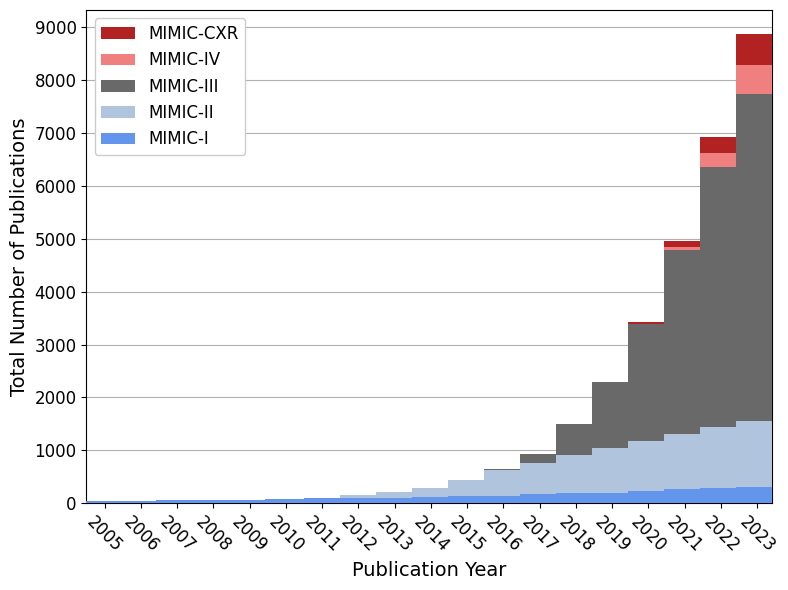

In [39]:
colors = [
    'cornflowerblue',
    'lightsteelblue',
    'dimgray',
    'lightcoral',
    'firebrick'
]
min_year = 2005
ytick_interval = 1000

years = [int(y) for y in google_scholar_mimic_pubs[list(google_scholar_mimic_pubs.keys())[0]].keys()]
db_order = ['mimic-i','mimic-ii','mimic-iii','mimic-iv','mimic-cxr']

plt.figure(figsize=(8,6))
graph_data = []
for db in google_scholar_mimic_pubs.keys():
    graph_data.append(np.concatenate(np.array([np.array(v*[int(y)]) for y,v in google_scholar_mimic_pubs[db].items()]).flatten()))
max_citations = np.concatenate(graph_data).shape[0]

plt.hist(graph_data, len(graph_data[0]), color=colors, label=[s.upper() for s in db_order], cumulative=1, stacked=True, density=False, zorder=3)
plt.xlim([min_year, max(years)-0.08])
plt.xticks(rotation=-45)
ax = plt.gca()
ax.tick_params(axis='both', which='major', labelsize=12)
ax.tick_params(axis='both', which='minor', labelsize=10)
ax.set_xticks(np.arange(min_year, max(years), 1) + 0.5)
ax.set_xticklabels(np.arange(min_year, max(years), 1), fontsize=12)
ax.set_yticks(np.arange(0, max_citations+ytick_interval, ytick_interval))
ax.set_yticklabels(np.arange(0, max_citations+ytick_interval, ytick_interval), fontsize=12)
plt.xlabel('Publication Year', fontsize=14)
plt.ylabel('Total Number of Publications', fontsize=14)
handles, labels = plt.gca().get_legend_handles_labels()
order = np.arange(len(db_order)-1, -1, -1)
legend = plt.legend([handles[i] for i in order], [labels[i] for i in order], loc='upper left', fontsize=12)
legend.get_frame().set_alpha(1)
plt.grid(zorder=-1, axis='y')
plt.tight_layout()
plt.savefig(os.path.join(SEARCH_RESULT_FOLDER, 'google_scholar', 'cumulative_histogram.png'))
plt.show()

# Plot the growth of each DB adjusted from the start time

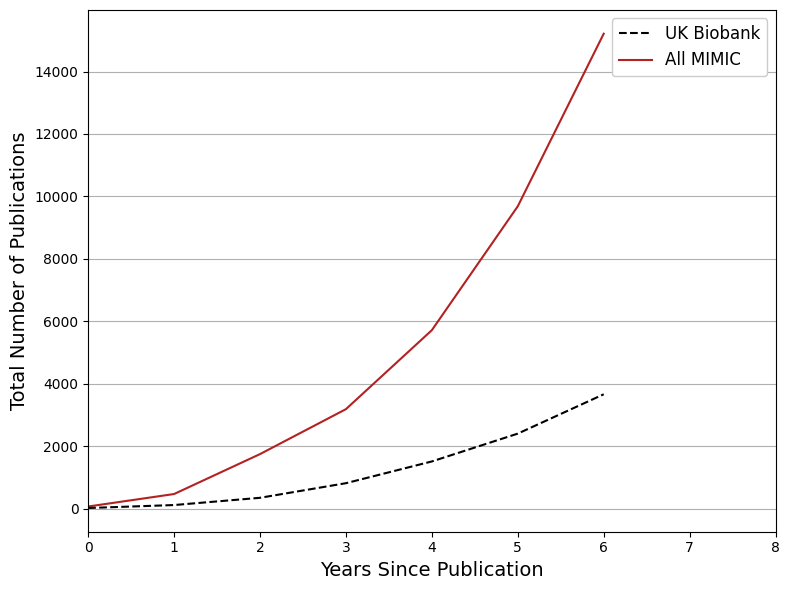

In [74]:
colors = [
    'cornflowerblue',
    'lightsteelblue',
    'dimgray',
    'lightcoral',
    'firebrick'
]
max_year = 2022
ALL_MIMIC = True

years = [int(y) for y in google_scholar_mimic_pubs[list(google_scholar_mimic_pubs.keys())[0]].keys()]
db_order = ['mimic-i','mimic-ii','mimic-iii','mimic-iv','mimic-cxr']

plt.figure(figsize=(8,6))

if ALL_MIMIC:
    all_x_data = []
    all_y_data = []
for i,db in enumerate(db_order):
    for y,v in google_scholar_mimic_pubs[db].items():
        if v != 0:
            start_year = int(y)
            break
    y_data = [v for y,v in google_scholar_mimic_pubs[db].items() if ((int(y) >= start_year) and (int(y) <= max_year))]
    y_data = np.cumsum(y_data)
    if ALL_MIMIC:
        all_y_data.append(y_data)
    else:
        x_data = range(len(y_data))
        plt.plot(x_data, y_data, color=colors[i], label=db.upper())
if ALL_MIMIC:
    max_len = max([len(a) for a in all_y_data])
    all_x_data = range(max_len)
    all_y_data = np.cumsum(np.sum([np.pad(a, (0, max_len-len(a)), 'constant') for a in all_y_data], axis=0))
    plt.plot(all_x_data[:7], all_y_data[:7], color=colors[i], label='All MIMIC')

closed_markers = [None, 'o', '^', 's']
for i,closed_dataset in enumerate(closed_datasets.items()):
    if closed_dataset[0] == 'UK Biobank':
        # UK Biobank for comparison
        start_year = int(list(closed_dataset[1].keys())[0])
        y_data = [v for y,v in closed_dataset[1].items() if ((int(y) >= start_year) and (int(y) <= max_year))]
        y_data = np.cumsum(y_data)
        x_data = range(len(y_data))
        plt.plot(x_data[:7], y_data[:7], color='k', linestyle='--', marker=closed_markers[i], label=closed_dataset[0])

plt.xlabel('Years Since Publication', fontsize=14)
plt.ylabel('Total Number of Publications', fontsize=14)
handles, labels = plt.gca().get_legend_handles_labels()
order = np.arange(len(labels)-1, -1, -1)
legend = plt.legend([handles[i] for i in order], [labels[i] for i in order], loc='upper right', fontsize=12)
legend.get_frame().set_alpha(1)
plt.grid(zorder=-1, axis='y')
plt.xlim([0,8])
plt.tight_layout()
# plt.savefig(os.path.join(SEARCH_RESULT_FOLDER, 'google_scholar', 'cumulative_line-plot_baseline.png'))
plt.show()

# Plot the growth of each DB adjusted from the start time and normalized by total funding received

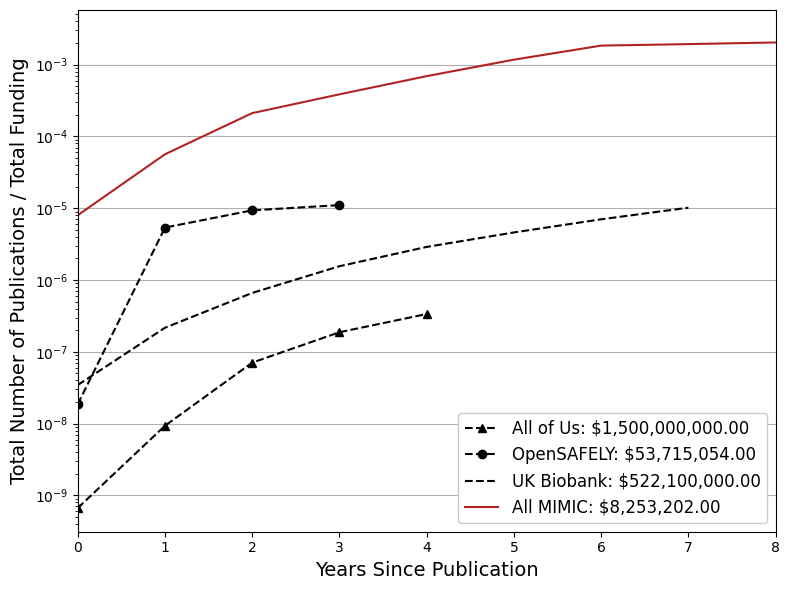

In [70]:
colors = [
    'cornflowerblue',
    'lightsteelblue',
    'dimgray',
    'lightcoral',
    'firebrick'
]
max_year = 2022
ALL_MIMIC = True

years = [int(y) for y in google_scholar_mimic_pubs[list(google_scholar_mimic_pubs.keys())[0]].keys()]
db_order = ['mimic-i','mimic-ii','mimic-iii','mimic-iv','mimic-cxr']

plt.figure(figsize=(8,6))

if ALL_MIMIC:
    all_x_data = []
    all_y_data = []
for i,db in enumerate(db_order):
    for y,v in google_scholar_mimic_pubs[db].items():
        if v != 0:
            start_year = int(y)
            break
    y_data = [v for y,v in google_scholar_mimic_pubs[db].items() if ((int(y) >= start_year) and (int(y) <= max_year))]
    y_data = np.cumsum(y_data)
    if ALL_MIMIC:
        all_y_data.append(y_data)
    else:
        x_data = range(len(y_data))
        plt.plot(x_data, y_data, color=colors[i], label=db.upper())
if ALL_MIMIC:
    max_len = max([len(a) for a in all_y_data])
    all_x_data = range(max_len)
    all_y_data = np.cumsum(np.sum([np.pad(a, (0, max_len-len(a)), 'constant') for a in all_y_data], axis=0))
    all_y_data = all_y_data/total_funding['MIMIC']
    total_funds = int(total_funding['MIMIC'])
    plt.plot(all_x_data, all_y_data, color=colors[i], label=f'All MIMIC: ${total_funds:,.2f}')

closed_markers = [None, 'o', '^', 's']
for i,closed_dataset in enumerate(closed_datasets.items()):
    # UK Biobank for comparison
    start_year = int(list(closed_dataset[1].keys())[0])
    y_data = [v for y,v in closed_dataset[1].items() if ((int(y) >= start_year) and (int(y) <= max_year))]
    y_data = np.cumsum(y_data)
    x_data = range(len(y_data))
    try:
        total_funds = int(total_funding[closed_dataset[0]])
        plt.plot(x_data, y_data/total_funding[closed_dataset[0]], color='k', linestyle='--', marker=closed_markers[i], label=f'{closed_dataset[0]}: ${total_funds:,.2f}')
    except KeyError:
        continue

plt.xlabel('Years Since Publication', fontsize=14)
plt.ylabel('Total Number of Publications / Total Funding', fontsize=14)
handles, labels = plt.gca().get_legend_handles_labels()
order = np.arange(len(labels)-1, -1, -1)
legend = plt.legend([handles[i] for i in order], [labels[i] for i in order], fontsize=12)
legend.get_frame().set_alpha(1)
plt.grid(zorder=-1, axis='y')
plt.xlim([0,8])
plt.yscale('log')
plt.tight_layout()
# plt.savefig(os.path.join(SEARCH_RESULT_FOLDER, 'google_scholar', 'cumulative_line-plot_baseline.png'))
plt.show()

# Compile all citations of MIMIC from Pubmed

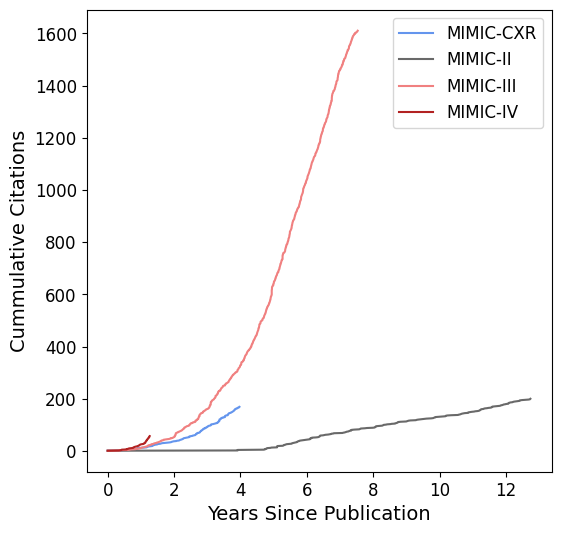

In [67]:
colors = [
    'cornflowerblue',
    # 'lightsteelblue',
    'dimgray',
    'lightcoral',
    'firebrick'
]
all_dbs = [f for f in os.listdir(MIMIC_PUBMED_CITATION_FOLDER) if f.endswith('.csv')]

plt.figure(figsize=(6,6))
MIMIC_citations = {}
for i,db in enumerate(all_dbs):
    db_name = db.split('.')[0]
    temp_df = pd.read_csv(os.path.join(MIMIC_PUBMED_CITATION_FOLDER, db))
    pub_dates = sorted([datetime.datetime.strptime(d,'%Y/%m/%d') for d in temp_df['Create Date'].tolist()])
    # if db_name == 'MIMIC-II':
    #     pub_dates = pub_dates[1:]
    plot_pub_dates = [(d-pub_dates[0]).days/365 for d in pub_dates]
    plt.plot(plot_pub_dates, range(1,len(plot_pub_dates)+1), color=colors[i], label=f'{db_name}')
    MIMIC_citations[db_name] = pub_dates
plt.xlabel('Years Since Publication', fontsize=14)
plt.ylabel('Cummulative Citations', fontsize=14)
plt.legend(fontsize=12)
# plt.yscale('log')
ax = plt.gca()
ax.tick_params(which='major', labelsize=12)
plt.show()

# Get the monthly rate of MIMIC citations

[[2008    0]
 [2009    0]
 [2010    0]
 [2011    0]
 [2012    0]
 [2013    0]
 [2014    0]
 [2015    0]
 [2016    2]
 [2017    5]
 [2018    7]
 [2019   14]
 [2020   21]
 [2021   36]
 [2022   39]
 [2023   46]]


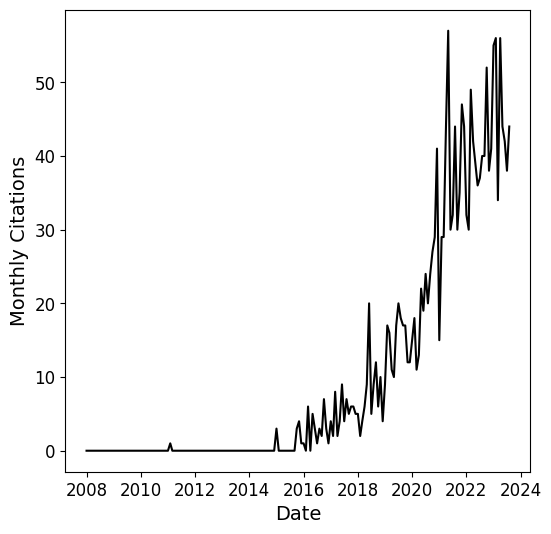

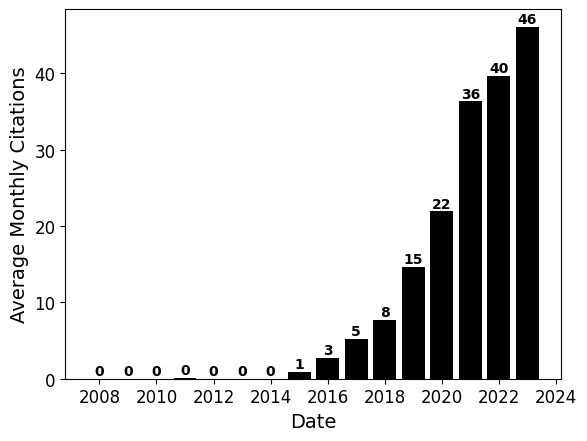

In [172]:
all_monthly_counts = {}
for db in MIMIC_citations.keys():
    all_monthly_counts[db] = dict(Counter([(d.year,d.month) for d in MIMIC_citations[db]]))
    # all_monthly_counts = sorted(Counter([(d.year,d.month) for d in MIMIC_citations[db]]).items(), key=lambda dd:dd[0][0])
    # print(db, all_monthly_counts)

# Find the average number of papers cited per month
all_days = list(range(1,31+1))
all_months = list(range(1,12+1))
all_years = range(2008,2023+1)
# citation_times = []
# for y in all_years:
#     for m in all_months:
#         for d in all_days:
#             try:
#                 dd = datetime.datetime(y,m,d)
#             except ValueError:
#                 continue
#             citation_times.append((y,m,d))
citation_times = [(y,m) for y in all_years for m in all_months]

total_monthly_citations = []
average_monthly_citations = []
for y,m in citation_times:
    temp_monthly_citations = 0
    for db in MIMIC_citations.keys():
        try:
            temp_monthly_citations += all_monthly_counts[db][(y,m)]
        except KeyError:
            temp_monthly_citations += 0
    average_monthly_citations.append((y,temp_monthly_citations))
    total_monthly_citations.append(temp_monthly_citations)

buffer_months = 4
average_monthly_citations = average_monthly_citations[:-buffer_months]
total_monthly_citations = total_monthly_citations[:-buffer_months]

average_monthly_citations = [np.mean([c for y,c in average_monthly_citations if y==yy]) for yy in all_years]
print(np.array(list(zip(all_years, average_monthly_citations))).astype(int))

plt.figure(figsize=(6,6))
x_dates = [datetime.datetime(y,m,1) for y,m in citation_times]
plt.plot(x_dates[:-buffer_months], total_monthly_citations, color='k')
plt.xlabel('Date', fontsize=14)
plt.ylabel('Monthly Citations', fontsize=14)
# plt.legend(fontsize=12)
# plt.yscale('log')
ax = plt.gca()
ax.tick_params(which='major', labelsize=12)
plt.show()

plt.figure()
plt.bar(all_years, average_monthly_citations, color='k')
ax = plt.gca()
for yy,y in enumerate(all_years):
    ax.text(y, average_monthly_citations[yy]+0.5, f'{average_monthly_citations[yy]:.0f}', horizontalalignment='center', color='k', fontweight='bold')
plt.xlabel('Date', fontsize=14)
plt.ylabel('Average Monthly Citations', fontsize=14)
# plt.legend(fontsize=12)
# plt.yscale('log')
ax = plt.gca()
ax.tick_params(which='major', labelsize=12)
plt.show()

In [173]:
# Total papers cited
np.sum([len(MIMIC_citations[k]) for k in MIMIC_citations])

2036